# Result Analysis: Estimation Analysis

The goal here is to understand if the Datamodels were capable to capture the relation in the training data and how it's working

In [1]:

import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
from src.utils import *
os.environ["CUDA_VISIBLE_DEVICES"] = "4"


## Part 1.1
from torch.utils.data import ConcatDataset, DataLoader
from src.datamodels.models import LinearRegressor

## Set seed and device
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/caio.rhoden/miniconda3/envs/datamodels/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datamodel_path = "../../../data/bbh/datamodels/reduced_sample"
df_train = pd.read_csv(f"{datamodel_path}/train_set.csv")
df_test = pd.read_csv(f"{datamodel_path}/test_set.csv")
weights = torch.load(f"{datamodel_path}/estimations/weights.pt")
bias = torch.load(f"{datamodel_path}/estimations/bias.pt")

/tmp/ipykernel_673539/3399502257.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{datamodel_path}/estimations/weights.pt")
/tmp/ipykernel_673539/3

In [3]:
weights = weights.cpu().detach().numpy()
bias = bias.cpu().detach().numpy()

In [4]:

df_test["weights"] = list(weights) 
df_test["bias"] = list(bias)

In [5]:
df_test["estimation_task"] = df_test["weights"].apply(lambda indices: [df_train.loc[i, "task"] for i in range(len(indices))])


In [6]:
test_collection = torch.load(f"{datamodel_path}/datasets/test/dt_0.pt", weights_only=False)
test_collections = torch.zeros((40, ))

In [7]:
## Load all test datasets
test_collections_path = f"{datamodel_path}/datasets/test"
test_collections = []
for i in range(0, 40):
    dataset =  torch.load(f"{test_collections_path}/dt_{i}.pt", weights_only=False)
    test_collections.append(dataset)

## Part 1: Is the Datamodel working?

The goal here is to understand if the trained datamodels are achieving the retrieval and interpretability expectation
</br>
To do so, we will look for three different things:
- Is it performing in the test collections?
- Is it able to distinguish the tasks in the training pool and correlate them to the test set?
- Is increasing the performance when comparing to the baseline?

### 1.1 - Is it performing in the test collections? 

Here we will get the performance of the datamodel for the test collections:
- Heatmap showing the MSE in test across all models
- Mean and Median MSE for each task
- Deep dive in interesting scenarios (TODO)

In [8]:
# test_mse = torch.zeros(40, 450)
# for i in range(0, 40):
#     model = LinearRegressor(160, 1)
#     _weights = df_test.loc[i, "weights"]
#     _bias = df_test.loc[i, "bias"]
#     model.load_state_dict({"linear.weight": torch.tensor(_weights).unsqueeze(0), "linear.bias": torch.tensor(_bias).unsqueeze(0)})
#     test_loader = DataLoader(test_collections[i], batch_size=1, shuffle=False)

#     count = 0
#     for x, y in test_loader:
#         mse = model.evaluate(x.to(device), y.to(device))
#         test_mse[i, count] = mse
#         count += 1


# torch.save(test_mse, "test_mse.pt")
test_mse = torch.load("test_mse.pt", weights_only=False)


#### Heatmap of MSEs in test

In [9]:
print(f"Max Mean MSE: {test_mse.mean(axis=1).max()}")
print(f"Min Mean MSE: {test_mse.mean(axis=1).min()}")

Max Mean MSE: 0.005016299430280924
Min Mean MSE: 0.0017957527888938785


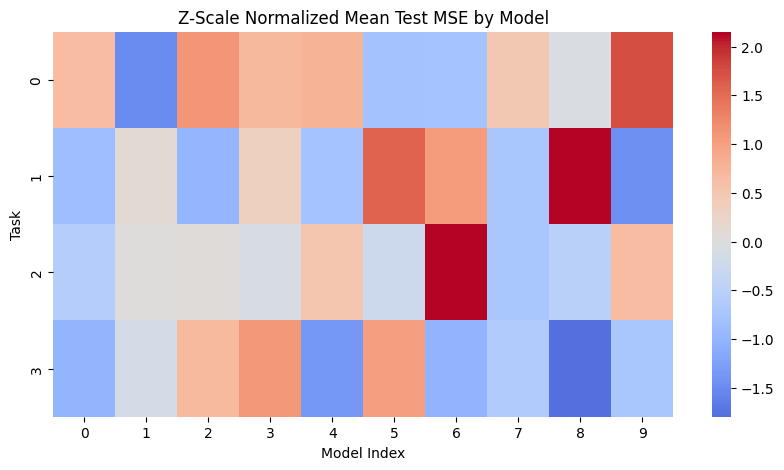

In [10]:
## Mean test mse by model
mean_test_mse = test_mse.mean(dim=1).cpu().detach().numpy()
plot_individual_heatmap_task_indication(
    mean_test_mse, 
    4,
    "Z-Scale Normalized Mean Test MSE by Model",
    "Task",
    "Model Index", 
)

#### Mean and Median MSE by Task

In [11]:
tasks = df_test["task"].unique()
mean_task_mse = np.zeros((4,))
median_task_mse = np.zeros((4,))
for i in range(1, 5):
    tasks_mses = test_mse[(10*(i-1)):10*i, :].reshape(4500)
    mean_task_mse[i-1] = tasks_mses.mean()
    median_task_mse[i-1] = np.median(tasks_mses)


df_mse_task = pd.DataFrame({
    "task": tasks,
    "mean": mean_task_mse,
    "median": median_task_mse
})

/work/caio.rhoden/datamodels-context-reduction/src/utils/utils.py:255: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


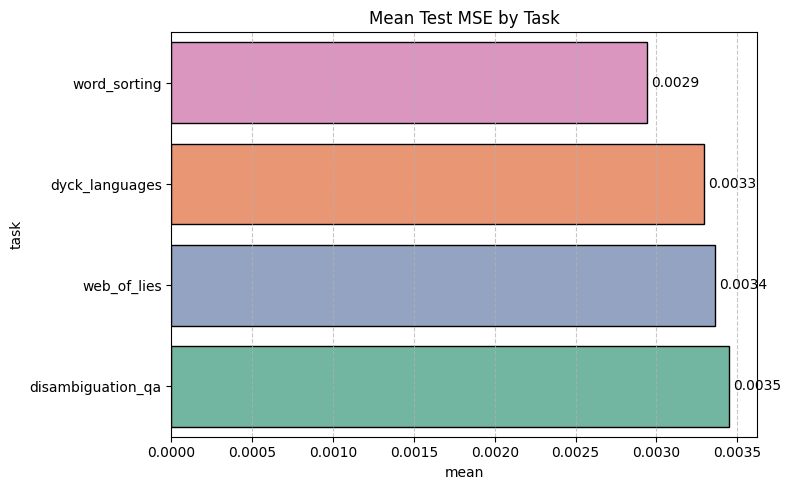

In [12]:
plot_barh(
    df = df_mse_task,
    y_axis= "task",
    x_axis= "mean",
    title= "Mean Test MSE by Task",
)

/work/caio.rhoden/datamodels-context-reduction/src/utils/utils.py:255: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


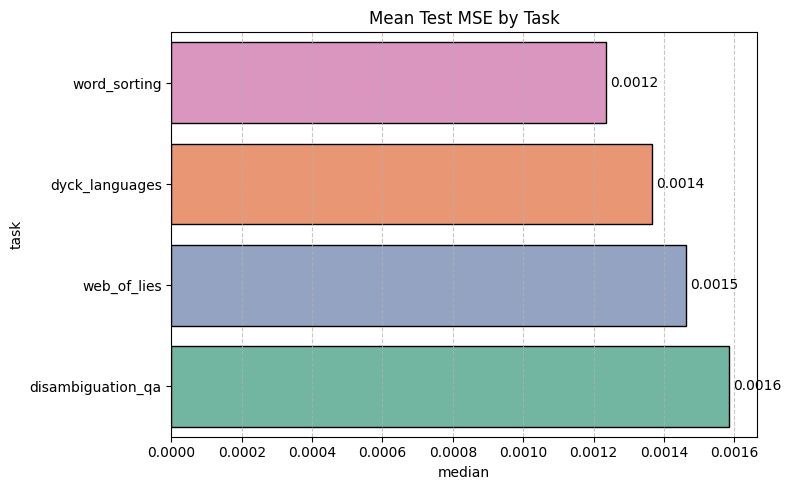

In [13]:
plot_barh(
    df = df_mse_task,
    y_axis= "task",
    x_axis= "median",
    title= "Mean Test MSE by Task",
)

### 1.2 - Is it able to distinguish the tasks in the training pool and correlate them to the test set?

Here we will work with a possibility to individual analysis over the results, to see where are the most impactful weights for a given test sample it's possible here to:
- see a heatmap of estimations on the training pool across all tasks
- see the i-th more influential samples

Globally, we can measure the ability to discern between tasks by analysing:
- Median quantity to reach the i-th most influential sample from the same task
- Median quantity of samples in the first quarter of most influential samples


In [14]:
## INDIVIDUAL

## Set datamodel idx
idx = 0

## i-th most influential sample
ith = 1


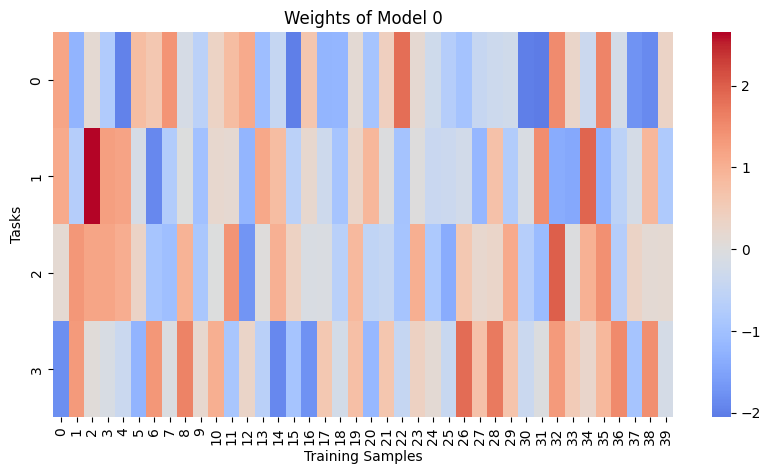

In [15]:
plot_individual_heatmap_task_indication(
    weights[idx], 
    4,
    f"Weights of Model {idx}", 
    "Tasks", 
    "Training Samples",
)


In [16]:
compare_i_most_high_samples(df_test, df_train, idx, ith)


Sample 0 input: In the following sentences, explain the antecedent of the pronoun (which thing the pronoun refers to), or state that it is ambiguous.
Sentence: The homeowner asked the inspector if the house she had purchased was structurally sound.
Options:
(A) The homeowner had purchased
(B) The inspector had purchased
(C) Ambiguous
Sample 0 output: (A)
1 Most influential input: Complete the rest of the sequence, making sure that the parentheses are closed properly. Input: < ( {
1 Most influential output: } ) >


In [17]:
compare_i_most_high_samples(df_test, df_train, idx, 2)


Sample 0 input: In the following sentences, explain the antecedent of the pronoun (which thing the pronoun refers to), or state that it is ambiguous.
Sentence: The homeowner asked the inspector if the house she had purchased was structurally sound.
Options:
(A) The homeowner had purchased
(B) The inspector had purchased
(C) Ambiguous
Sample 0 output: (A)
2 Most influential input: Question: Maybelle tells the truth. Osvaldo says Maybelle lies. Kandi says Osvaldo lies. Jerry says Kandi lies. Alejandro says Jerry lies. Does Alejandro tell the truth?
2 Most influential output: Yes


In [18]:
### GLOBAL


#### Median i-th appeareance of the same task

/work/caio.rhoden/datamodels-context-reduction/src/utils/utils.py:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


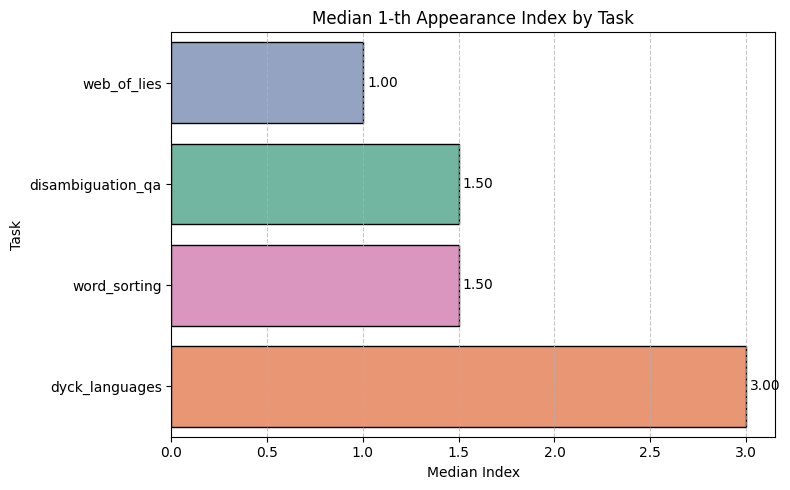

In [19]:
median_category_i_appearance(df_test, 1)


/work/caio.rhoden/datamodels-context-reduction/src/utils/utils.py:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


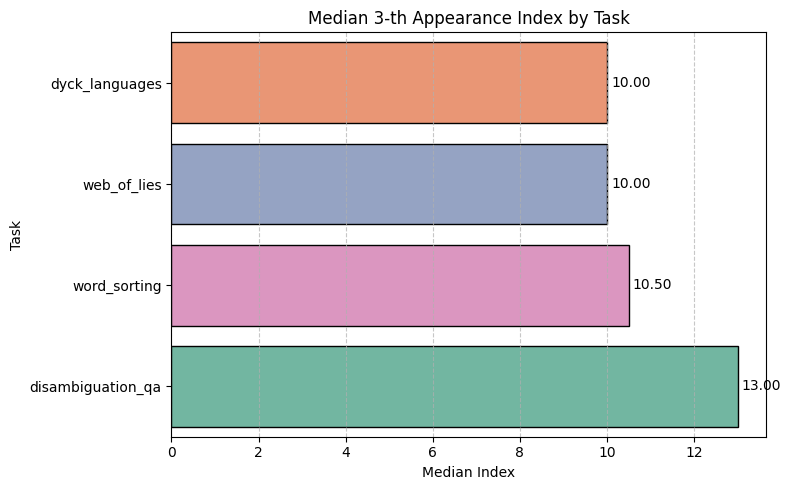

In [20]:
median_category_i_appearance(df_test, 3)


#### % of samples of the same task on the first quarter of highest weights

/work/caio.rhoden/datamodels-context-reduction/src/utils/utils.py:222: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


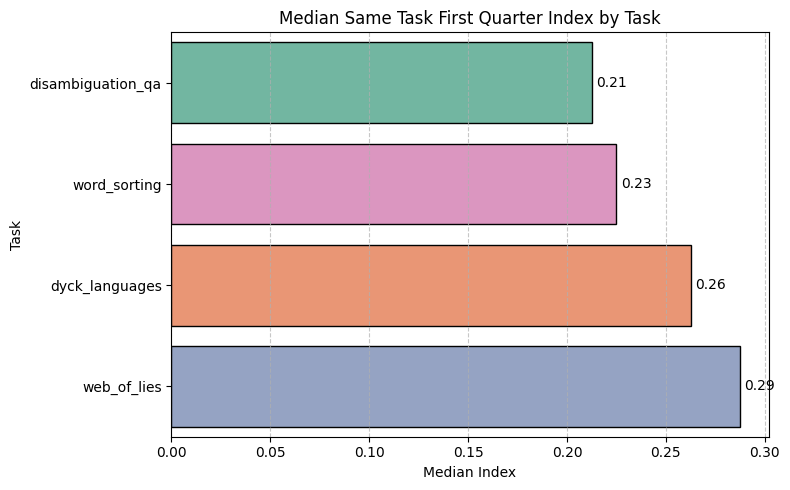

In [21]:
median_same_task_first_quarter(df_test)

### 1.3 Is it increasing the performance when comparing to the baseline?

The goal of this section is to analyze how the samples with the best weights perform in comparison with the baseline results
</br>
The metric used is the Google BLEU (Gleu)
</br>
The analysis will be:
- GLEU mean difference heatmap by model
- GLEU viz difference baseline x any and baselune x task
- Mean/Median differences by task (Any and Task scenarios)

In [22]:
from src.evaluator import GleuEvaluator
from src.llms import Llama3_1_Instruct
from langchain.prompts import PromptTemplate
import json

intructions_path = f"{datamodel_path}/instructions.json"
with open(intructions_path, "r") as f:
        instructions = json.load(f)

evaluator = GleuEvaluator()


In [23]:
def fill_prompt_template(
            idx_test: int,
            train: pd.DataFrame,
            test: pd.DataFrame,
            instructions: dict,
            input_column: str = "input",
            output_column: str = "output",
            task_column: str = "task",
        ) -> str:
        
        template = """
            Fill the expected Output according to the instruction
            Intruction: {instruction}

            Examples:
            {context}

            User Input:
            {input}

            Model Output:
        """

        context = ""
        for idx in range(len(train)):
            input = train.iloc[idx][input_column]
            output = train.iloc[idx][output_column]
            context += f"Input: {input} \nOutput: {output}\n"

        
        input = test.loc[idx_test][input_column]

        instruction =instructions[test.iloc[idx_test][task_column]]
        prompt = PromptTemplate.from_template(template).format(instruction=instruction, context=context, input=input)

        return prompt

In [24]:
def get_best_context_by_model(mode: str) -> np.ndarray:
    best_context = np.zeros((40, 8))
    _df = df_test.copy()

    

    if mode == "any":
        for i in range(0, 40):
            _model_weights = _df.loc[i, "weights"]
            _model_weights = np.array(_model_weights)

            _indices = np.argpartition(_model_weights, -8)[-8:]
            sorted_indices = _indices[np.argsort(_model_weights[_indices])][::-1]
            best_context[i] = sorted_indices
    
    else:
        for i in range(0, 40):
            row = _df.loc[i]
            task = row["task"]

            _model_weights = [f for s, f in zip(row["estimation_task"], row["weights"]) if s == task]
            _model_weights = np.array(_model_weights)
            _indices = np.argpartition(_model_weights, -8)[-8:]
            sorted_indices = _indices[np.argsort(_model_weights[_indices])][::-1]
            best_context[i] = sorted_indices
    
            
    


    return best_context

def retrieve_best_context(arr: np.ndarray) -> pd.DataFrame:

    return df_train.iloc[arr.flatten()]

    

    

In [25]:
# baseline_path = "../../../data/bbh/baseline/Meta-Llama-3.1-8B/0_39.feather"
# baseline_results = pd.read_feather(baseline_path)

# baseline_results["evaluation"] = evaluator.evaluate(df_test["output"].to_numpy(), baseline_results["predicted"].to_numpy(), possible_outputs=None)

# results = df_test.copy()
# results["basline_evaluation"] = baseline_results["evaluation"]

# any_idx = get_best_context_by_model(mode = "any")
# task_idx = get_best_context_by_model(mode = "task")

# any_inputs = [fill_prompt_template(i, retrieve_best_context(any_idx[i]), df_test, instructions) for i in range(40)]
# task_inputs = [fill_prompt_template(i, retrieve_best_context(task_idx[i]), df_test, instructions) for i in range(40)]


# llm = Llama3_1_Instruct(path = "../../../models/llms/Llama-3.1-8B-Instruct")
# pred_any = [llm.run(input) for input in any_inputs]
# pred_task = [llm.run(input) for input in task_inputs]

# results["any_results"] = evaluator.evaluate(df_test["output"].to_numpy(), np.array(pred_any), possible_outputs=None)
# results["task_results"] = evaluator.evaluate(df_test["output"].to_numpy(), np.array(pred_task), possible_outputs=None)

# results.to_csv("results.csv", index=False)

results = pd.read_csv("results.csv")





#### Heatmap Difference Baseline x Best Weights

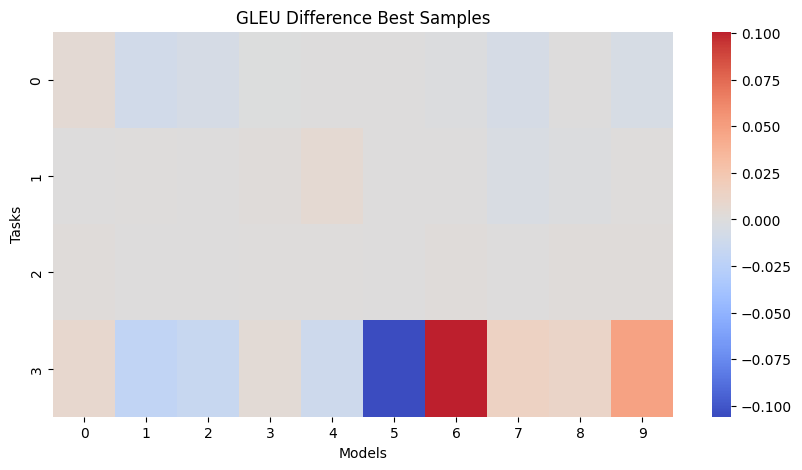

In [26]:
_gleu_diff_any = results["any_results"] - results["basline_evaluation"]
plot_individual_heatmap_task_indication(
    np.array(_gleu_diff_any), 
    4,
    f"GLEU Difference Best Samples", 
    "Tasks", 
    "Models",
    scaler=False
)

#### Differences By Model: Baseline x Best Examples x Best by Task

In [45]:
_gleu_diff_any = np.array(results["any_results"] - results["basline_evaluation"])
_gleu_diff_task = np.array(results["task_results"] - results["basline_evaluation"])
_diffs = np.concatenate((_gleu_diff_any, _gleu_diff_task))

_tasks = 2 * df_test["task"].tolist()
_tag = ["any"] * 40 + ["task"] * 40

df_diffs = pd.DataFrame({
    "task": _tasks,
    "tag": _tag,
    "diff": _diffs
})


In [48]:
-_gleu_diff_task

array([-5.77378793e-03,  1.76315512e-02,  4.81892875e-04, -5.83090379e-03,
        5.30905741e-03, -2.68605250e-03, -5.14919801e-03,  5.99653351e-03,
        1.51896042e-04, -4.51372926e-04, -2.16802168e-05, -1.25944584e-03,
        2.87778391e-03, -1.28336205e-03, -2.66651736e-03,  2.31497558e-05,
        1.29495937e-05,  2.83732441e-03,  2.16119744e-04, -1.40722082e-03,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -1.52905199e-03,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -1.84501845e-03, -0.00000000e+00, -8.42995776e-03,  1.22835280e-02,
        1.95900670e-02,  2.51068141e-03,  5.29595016e-02,  1.50370880e-01,
       -2.16336699e-03, -1.44535580e-02, -4.81544374e-02,  8.29596413e-02])

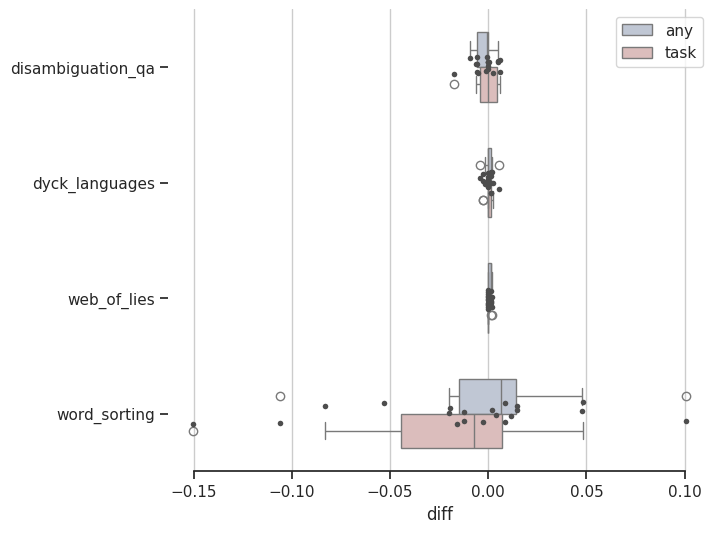

In [53]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
# ax.set_xscale("log")



# Plot the orbital period with horizontal boxes
sns.boxplot(
    df_diffs, x="diff", y="task", hue="tag", width=.6, palette="vlag"
)

# Add in points to show each observation
# sns.stripplot(df_diffs, x="diff", y="task", size=4, color=".3")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)